# CA2 - Machine Learning

In [1]:
#@title Copyright 2020 Google LLC. Double-click for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
%tensorflow_version 2.x

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
tf.keras.backend.set_floatx('float32')

np.set_printoptions(precision=4)

## Question 1
Show that the normal equations minimize the sum of the squares of the errors between the desired outputs and the actual outputs on the training data. Write the equation in terms of 𝑥̂ where 𝑥̂ is the desired output.

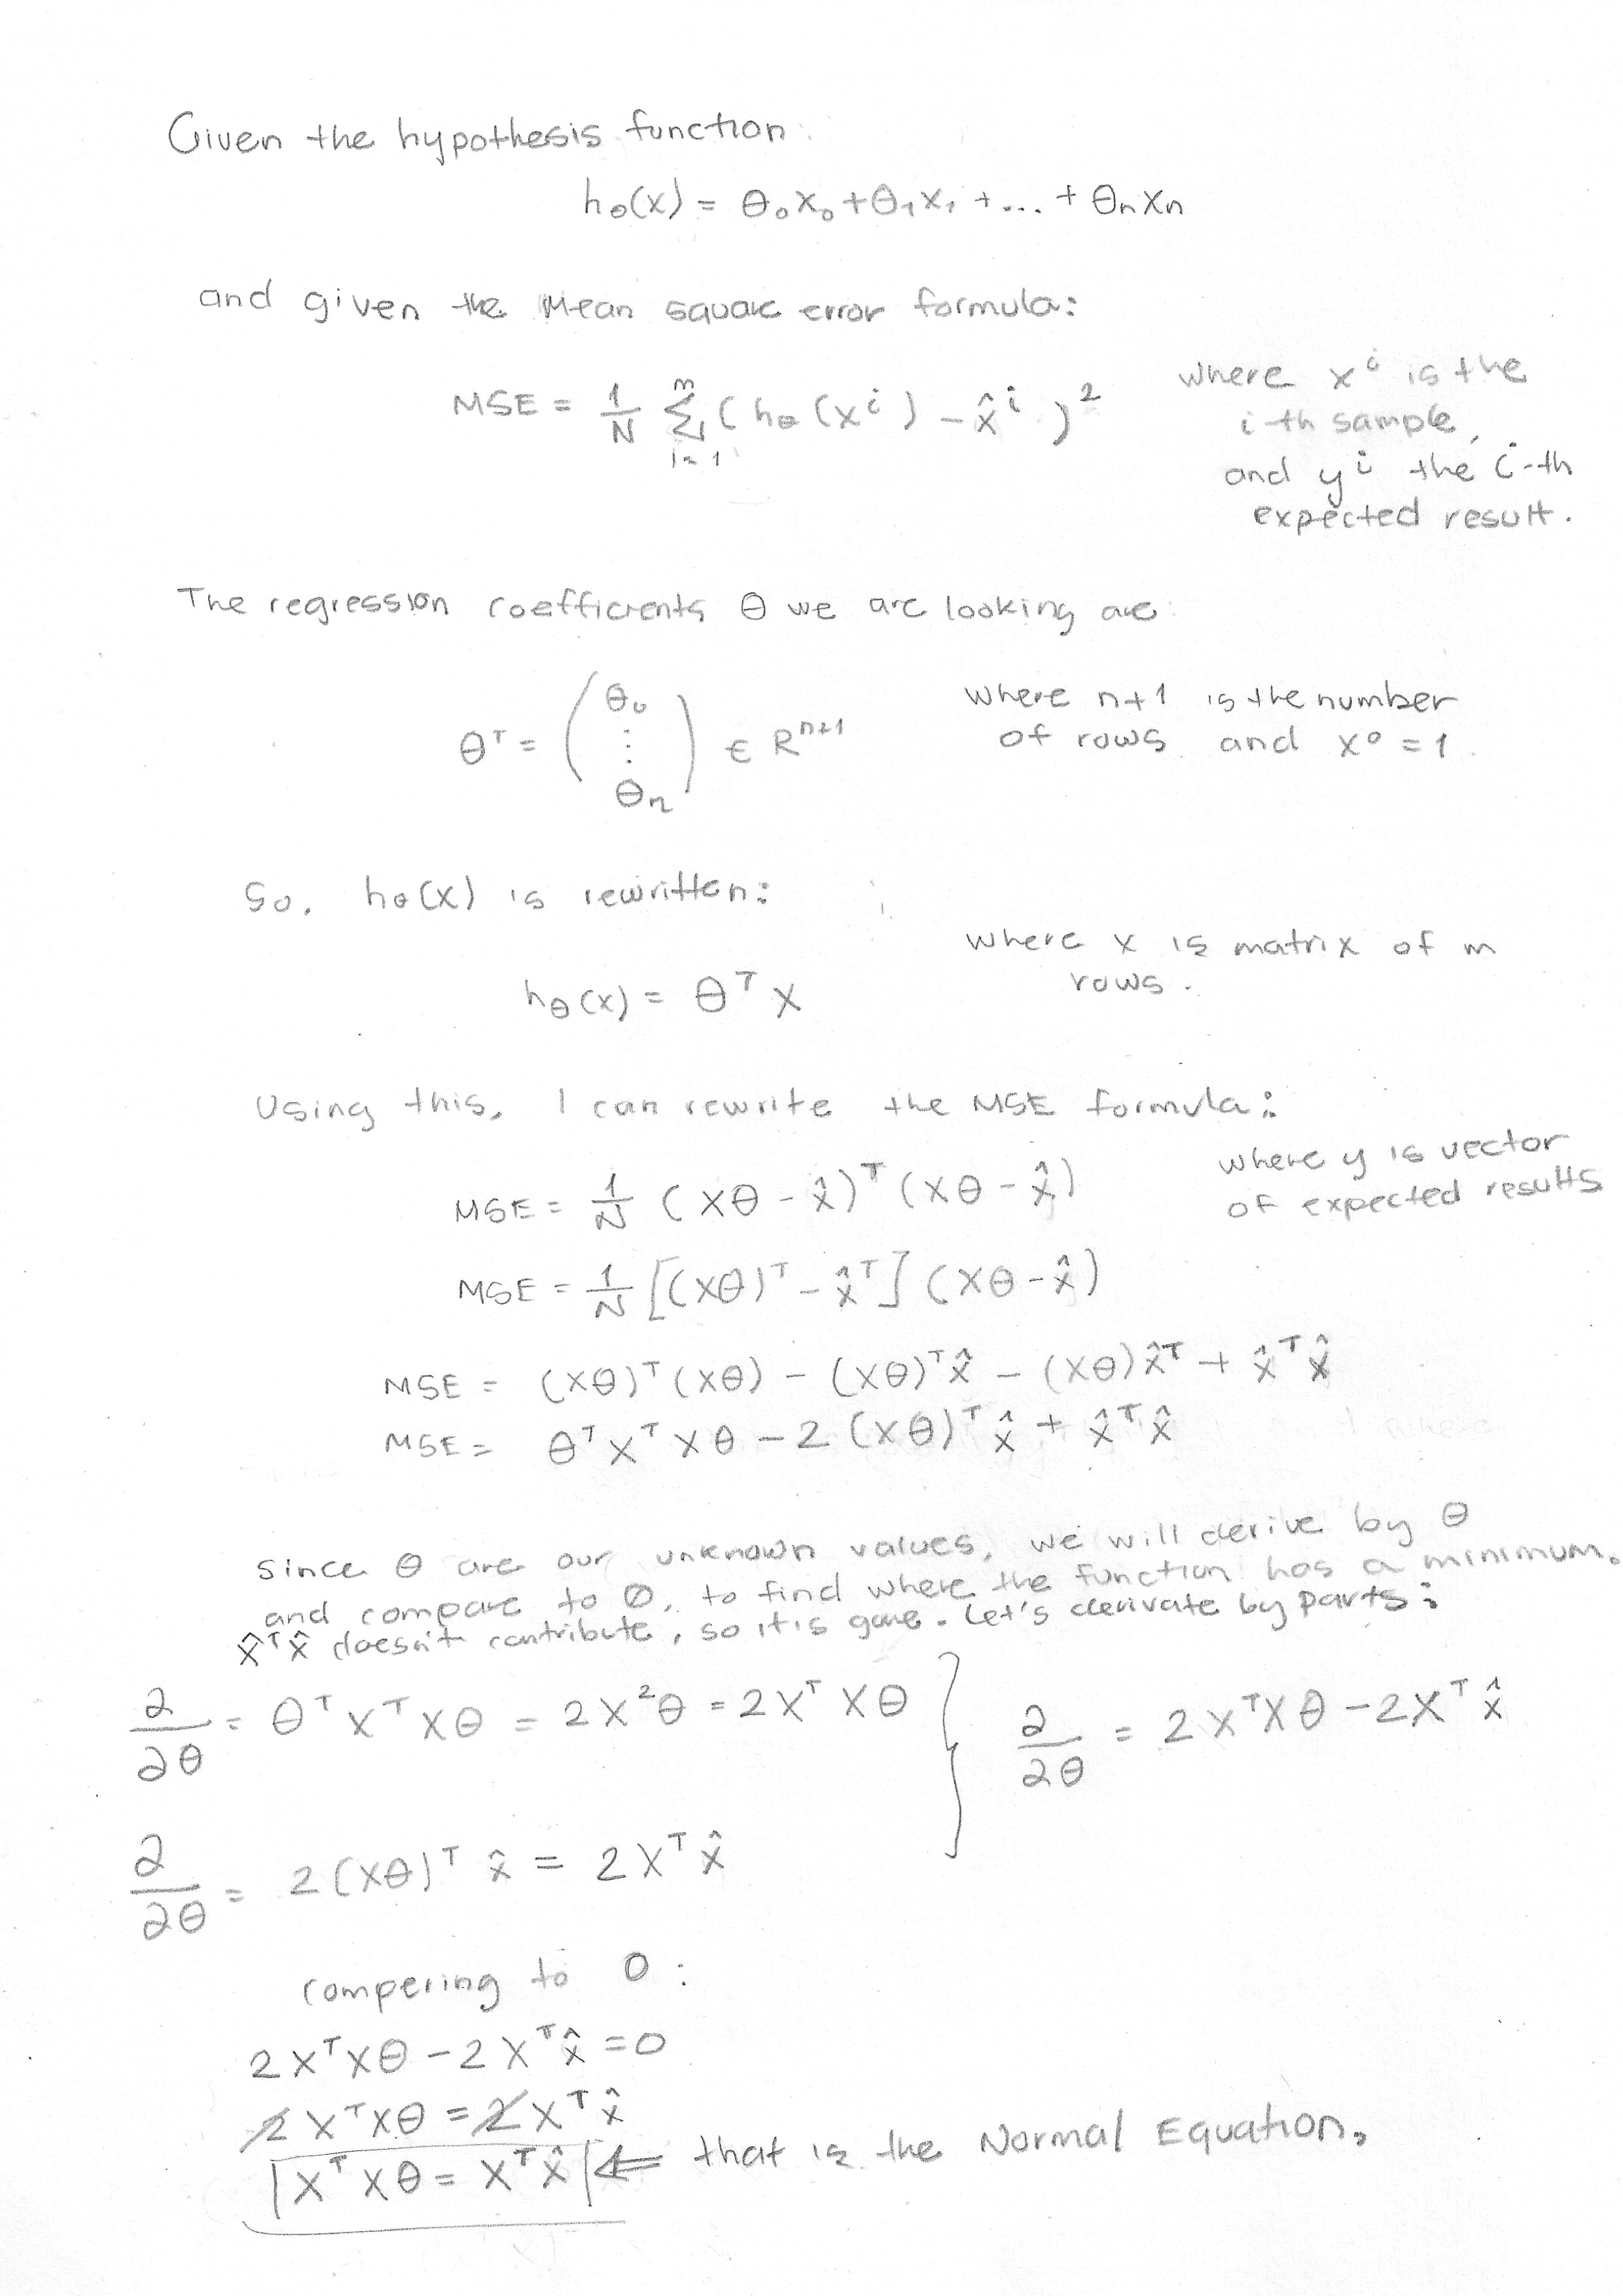

## Question 2

1. Pick any two features other than longitude, latitude and median_house_value from the California housing dataset for representation with a feature cross. You can scale and/or create a synthetic feature(s) from the dataset. Give reason(s) for your selection.
2. Obtain a feature cross using the selected features in (1), train the model with floating point representation and observe the results
3. Using the feature cross in (2), train the model with bucket representation and observe the results
4. Document your findings in (2) and (3) explaining the loss function, bucket size, bucket resolution, model performance, tuning of hyper-parameters. Use appropriate visualisation in your documentation.

### Model

In [4]:
#@title Define functions to create and train model
def create_model(my_learning_rate, feature_layer):
  
  model = tf.keras.models.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, 
                      y=label, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      shuffle=True)

  epochs = history.epoch
  
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse


print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [5]:
#@title Define the plotting functions
def plot_the_loss_curve(epochs, rmse):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


### The Dataset
  
This CA uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

In [6]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [8]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


### Synthetic features

In [9]:
# total rooms per population can give more information than separate values.
# create a synthetic features
train_df['rooms_per_population'] = train_df['total_rooms'] / train_df['population']
test_df['rooms_per_population'] = test_df['total_rooms'] / test_df['population']

# total bedrooms per population can give more information than separate values.
# create a synthetic features
train_df['bedrooms_per_population'] = (train_df['total_bedrooms'] / train_df['population'])
test_df['bedrooms_per_population'] = (test_df['total_bedrooms'] / test_df['population'])

### Choosing features
*1. Pick any two features other than longitude, latitude and median_house_value from the California housing dataset for representation with a feature cross. You can scale and/or create a synthetic feature(s) from the dataset. Give reason(s) for your selection.*

In this case, my label (dependen variable, my research question) is **median_house_value**. For chossing features (independen variables), I am going to look at the correlation table, and pick the freatures with max absolute values than zero.

In [10]:
mycolumns = ['housing_median_age', 'total_rooms',
             'total_bedrooms', 'population', 'households', 'median_income',
             'median_house_value', 'rooms_per_population', 'bedrooms_per_population']
mylabel = "median_house_value"

In [11]:
train_df[mycolumns].corr()[[mylabel]]

,median_house_value
housing_median_age,0.1
total_rooms,0.1
total_bedrooms,0.0
population,-0.0
households,0.1
median_income,0.7
median_house_value,1.0
rooms_per_population,0.2
bedrooms_per_population,0.1


Since we are going to work with feature cross, I am going to pick **median_income** and **housing_median_age** to bin them later on. Additionally, these features have high correlation value with label selected **median_house_value**. What is more, I believe these features add contribution to the model.

***Note: median_income as a feature could bring ethical and fairness issues up. For the porpouse of this CA2, i am going to continute with this feature.***

In [12]:
train_df[['housing_median_age', 'median_income', 'median_house_value']].head()

,housing_median_age,median_income,median_house_value
0,15.0,1.5,66900.0
1,19.0,1.8,80100.0
2,17.0,1.7,85700.0
3,14.0,3.2,73400.0
4,20.0,1.9,65500.0


### Scaling

In [13]:
# I am going to scale this as it would help to compute less while training the model.
train_df["median_house_value"] /= 1000.0
test_df["median_house_value"] /= 1000.0

### Dealing with outliers

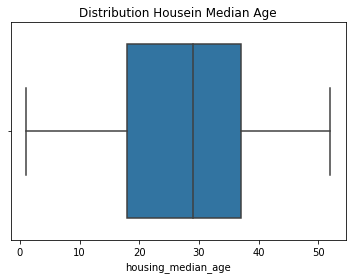

In [14]:
# Plot housing median age to see the shape of the distribution of the data.
sns.boxplot(data = train_df, x="housing_median_age")
plt.title("Distribution Housein Median Age")
plt.show()
# Looks ok,

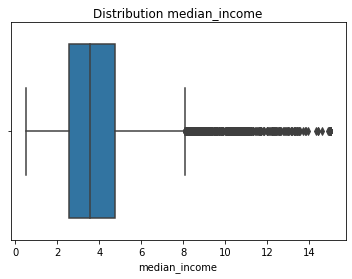

In [15]:
# Plot median income to see the shape of the distribution of the data.
sns.boxplot(data=train_df, x="median_income")
plt.title("Distribution median_income")
plt.show()
# It is skewed to the right, lets apply a transformation for a bell shape.

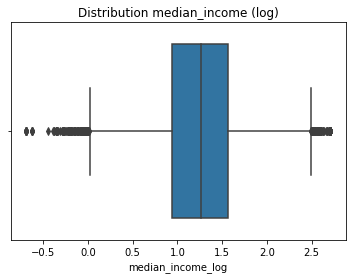

In [16]:
# Lets apply log transformation.
train_df["median_income_log"] = np.log(train_df["median_income"])
test_df["median_income_log"] = np.log(test_df["median_income"])

# And plot
sns.boxplot(data=train_df, x="median_income_log")
plt.title("Distribution median_income (log)")
plt.show()

# looks better

### Crossing features selected
2. Obtain a feature cross using the selected features in (1), train the model with floating point representation and observe the results

In [17]:
train_df[['housing_median_age', 'median_income_log']].describe()

,housing_median_age,median_income_log
count,17000.0,17000.0
mean,28.6,1.2
std,12.6,0.5
min,1.0,-0.7
25%,18.0,0.9
50%,29.0,1.3
75%,37.0,1.6
max,52.0,2.7


In [18]:
# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

median_income_as_a_numeric_column = tf.feature_column.numeric_column("median_income_log")
housing_median_age_as_a_numeric_column = tf.feature_column.numeric_column("housing_median_age")

# Create a bucket feature column for median_income.
median_income_boundaries = list(np.around(np.arange(int(min(train_df['median_income_log'])), 
                                     int(max(train_df['median_income_log'])), 
                                     0.4),decimals=2))
median_income = tf.feature_column.bucketized_column(median_income_as_a_numeric_column, boundaries=median_income_boundaries)

# Create a bucket feature column for housing_median_age.
housing_median_age_boundaries = list(np.around(np.arange(int(min(train_df['housing_median_age'])), 
                                     int(max(train_df['housing_median_age'])), 
                                     10.3), decimals=2))
housing_median_age = tf.feature_column.bucketized_column(housing_median_age_as_a_numeric_column, boundaries=housing_median_age_boundaries)

# Create a feature cross of median_income and housing_median_age.
median_income_x_housing_median_age = tf.feature_column.crossed_column([median_income, housing_median_age], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(median_income_x_housing_median_age)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

In [19]:
median_income_boundaries

[0.0, 0.4, 0.8, 1.2, 1.6]

In [20]:
housing_median_age_boundaries

[1.0, 11.3, 21.6, 31.9, 42.2]

### Train the model with floating-point representations

The following code cell calls the functions you just created to train, plot, and evaluate a model.

In [21]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

housing_median_age_as_a_numeric_column = tf.feature_column.numeric_column("housing_median_age")
feature_columns.append(housing_median_age_as_a_numeric_column)

median_income_as_a_numeric_column = tf.feature_column.numeric_column("median_income_log")
feature_columns.append(median_income_as_a_numeric_column)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
850/850 [==============================] - 2s 2ms/step - loss: 23506.1726 - root_mean_squared_error: 152.2423
Epoch 2/30
850/850 [==============================] - 1s 2ms/step - loss: 13744.7318 - root_mean_squared_error: 117.2162
Epoch 3/30
850/850 [==============================] - 1s 2ms/step - loss: 11516.9864 - root_mean_squared_error: 107.2989
Epoch 4/30
850/850 [==============================] - 1s 2ms/step - loss: 9791.7593 - root_mean_squared_error: 98.9429
Epoch 5/30
850/850 [==============================] - 1s 2ms/step - loss: 8647.7550 - root_mean_squared_error: 92.9812
Epoch 6/30
850/850 [==============================] - 1s 2ms/step - loss: 8298.4803 - root_mean_squared_error: 91.0863
Epoch 7/30
850/850 [==============================] - 1s 2ms/step - loss: 8104.0816 - root_mean_squared_error: 90.0139
Epoch 8/30
850/850 [==============================]

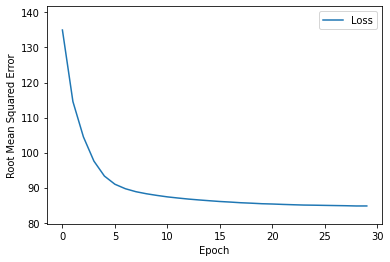


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
150/150 [==============================] - 0s 1ms/step - loss: 7226.4521 - root_mean_squared_error: 85.0085


[7226.4521484375, 85.008544921875]

In [22]:
# The following variables are the hyperparameters.
learning_rate = 0.03
epochs = 30
batch_size = 20

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, mylabel)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(mylabel))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

### Train the model with bucket representations
3. Using the feature cross in (2), train the model with bucket representation and observe the results

Epoch 1/70
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1134/1134 [==============================] - 3s 3ms/step - loss: 55214.3068 - root_mean_squared_error: 234.9428
Epoch 2/70
1134/1134 [==============================] - 3s 3ms/step - loss: 48193.7333 - root_mean_squared_error: 219.4964
Epoch 3/70
1134/1134 [==============================] - 3s 3ms/step - loss: 40434.9066 - root_mean_squared_error: 201.0710
Epoch 4/70
1134/1134 [==============================] - 3s 3ms/step - loss: 35602.5406 - root_mean_squared_error: 188.6590
Epoch 5/70
1134/1134 [==============================] - 3s 3ms/step - loss: 29621.5851 - root_mean_squared_error: 172.1005
Epoch 6/70
1134/1134 [==============================] - 3s 3ms/step - loss: 26018.9330 - root_mean_squared_error: 161.2638
Epoch 7/70
1134/1134 [==============================] - 3s 3ms/step - loss: 22141.5966 - root_mean_squared_error: 148.7749
Epoch 8/70
1134/1134 [=======

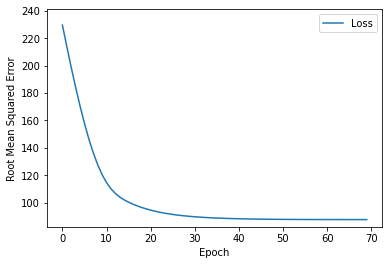


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
200/200 [==============================] - 0s 2ms/step - loss: 7584.8481 - root_mean_squared_error: 87.0910


[7584.84814453125, 87.09103393554688]

In [23]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 70
batch_size = 15

# Create and compile the model's topography.
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, mylabel)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(mylabel))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

### Interpretation
4. Document your findings in (2) and (3) explaining the loss function, bucket size, bucket resolution, model performance, tuning of hyper-parameters. Use appropriate visualisation in your documentation.

#### When train the model with floating-point representations
* After playing for a while with the **learning rate**, **epchos** and **batch size**, I found a good combination of these hyper-parameters to get the lowest **loss function** value that is roughly **7117.0156**.
* I found out a better loss function with the **learning rate** between 0.02 and 0.09, however with the last rate I had to incresea the number of epchos.
* The final values for the hyper-parameters that I used were: **learning-rate: 0.03**, **epchos: 30**, and **batch size: 20**.
* It is important to point out that the loss function for the evaluation process have roughly the same value. 

#### When train the model with bucket representations
* I tried to used the same hyper-parameters like in the "floating-point representations", however the loss function and root_mean_squared_error had greater values. I decided to play for some minutes with the hyper-parameters.
* By playing around with the bucket resolution, the good combination I found was is on buckets with the same size, in this case size 5. For the **median_income**, since this feature was transformed I took 0.4 to form a 5 size bucket. For the **housing_median_value**, the resolution is per every 10.3 years. Less buckets increases the value of the loss function since the lack of examples.
* After playing for a while with the **learning rate**, **epchos** and **batch size**, I found a good combination of these hyper-parameters to get the lowest **loss function** value that is **7754.3344**.
* I found out a better loss function with the **learning rate** between 1 and 0.1
* The final values for the hyper-parameters that I used were: **learning-rate: 0.01**, **epchos: 70**, and **batch size: 15**.

#### Comparison between models
By looking at the loss functions, it is noticable that the first model has a better performance since its loss function has a lower value. Therefore, it is not necessary, in this case, to cross the features.




# Question 3
Implement an algorithm in python (colab), that computes the MSE and LMS weights for a single layer perceptron. Your functions should take training sets as inputs and produce
weights as outputs. Additionally, the LMS function should take a learning rate as an input and you could, if you wish, add a flag that indicates use of the Hessian - Optional. Also, the MSE function should perform quadratic regularization and 𝑙𝑎𝑚𝑏𝑑𝑎≥0 should be an input.
Apply your implemented algorithms to the following problems:

**(a)** Gaussian classification problem. Generate two classes from two Gaussian distributions using random function in python. Try a variety of Gaussians. Make unusually shaped Gaussians and make some linearly separable and some not linearly separable

**(b)** Sine wave regression. Generate pairs of inputs and outputs from sin(2px) . More
specifically, take yi = sin(2pxi ) +e , i = 1, …, m, where e is zero-mean Gaussian noise and m is in the neighbourhood of 5 – 10. Use the MSE algorithm to find a polynomial fit for polynomials of order 0, 1, 3, and 9. Once you learn the coefficients of the polynomial, plot the polynomial for x for 0 to 1 with a resolution of 0.01.
Note: the red text marked above is optional task.

### Functions to create and train Model

In [24]:
# Global variables ----------------------------------------------
_activation_dic = {0:'linear', 1:'sigmoid', 2:'relu'}

In [25]:
# Methods -------------------------------------------------------
def split_dataset(df_, features_, label_, test_size_, display_=True):
  
  X_train, X_test, y_train, y_test = train_test_split(df_[features_], df_[label_], test_size = test_size_)

  concat = lambda x,y: pd.concat([pd.DataFrame(x), pd.DataFrame(y)], axis=1)

  df_train = concat(X_train, y_train)
  df_test = concat(X_test, y_test)

  if display_:
    print('Length dataset', len(df_))
    print('Train subset', len(df_train))
    print('Test subset', len(df_test))

  return df_train, df_test

In [26]:
def prepare_numericFeatures(features_):
  
  feature_columns = []

  for i in features_:
    feature_columns.append(tf.feature_column.numeric_column(i))

  return tf.keras.layers.DenseFeatures(feature_columns)

In [27]:
def create_model(features_layer_, learning_rate_, regularization_rate_, activation_):

  model = tf.keras.models.Sequential()

  model.add(features_layer_)

  model.add(tf.keras.layers.Dense(1,
                                  activation = activation_,                                 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2=regularization_rate_),
                                  name = "single_layer_p"
                                  ))
  
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=learning_rate_),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.MeanSquaredError()])
  
  return model

In [28]:
def train_model(model_, train_df_, label_name_, epochs_, batch_size_, validation_split_):

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in train_df_.items()}
  label = np.array(features.pop(label_name_))
  
  history = model_.fit(x = features, 
                      y = label, 
                      batch_size = batch_size_,
                      epochs = epochs_, 
                      validation_split = validation_split_,
                      shuffle = True) 

  trained_weight = model_.get_weights()[0]
  trained_bias = model_.get_weights()[1]

  epochs = history.epoch
  
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]
  mse_val = hist["val_mean_squared_error"]

  return trained_weight, trained_bias, epochs, mse, mse_val

In [29]:
def evaluate_model(test_df_, model_, batch_size_):

  # Split the dataset into features and label.
  test_features = {name:np.array(value) for name, value in test_df_.items()}
  test_label = np.array(test_features.pop(mylabel))

  print("\n Evaluate the new model against the test set:")
  model_.evaluate(x = test_features, y = test_label, batch_size = batch_size_)

In [30]:
def execute_model(train_df_, test_df_, label_name_, features_layer_, learning_rate_, regularization_rate_, activation_, epochs_, batch_size_, validation_split_):
  
  # create model
  my_model = create_model(features_layer_, learning_rate_, regularization_rate_, activation_)

  # train and plot model
  trained_weight, trained_bias, epochs, mse, mse_v = train_model(my_model, train_df_, label_name_, epochs_, batch_size_, validation_split_)
  plot_the_loss_curve(epochs, mse, mse_v) 

  # evaluate model
  evaluate_model(test_df_, my_model, batch_size_)

  return trained_weight, trained_bias

In [31]:
#@title Define the plotting functions
def plot_the_loss_curve(epochs_, mse_, mse_v_):
  
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs_[1:], mse_[1:], label="Training Loss")
  plt.plot(epochs_[1:], mse_v_[1:], label="Validation Loss")
  plt.legend()
  
  merged_mae_lists = mse_[1:] + mse_v_[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()   

def plot_the_model(df, trained_weight, trained_bias, feature, label):

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = df
  plt.scatter(random_examples[feature], random_examples[label], s=10)

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = min(df.input)
  y0 = trained_bias
  x1 = max(df.input)
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


### Gaussian Classification Problem
Generate two classes from two Gaussian distributions using random function in python. Try a variety of Gaussians. Make unusually shaped Gaussians and make some linearly separable and some not linearly separable

In [32]:
#@title Function to generate gaussian dataset.
def built_gaussianDataset(mean_, std_, sample_, type_class_):
  
  data = np.random.normal(loc=mean_, scale=std_, size=sample_)
  df_ = pd.DataFrame([data]).T
  df_.columns = ['value']
  df_['class'] = type_class_

  return df_

print("built_gaussianDataset function created.")

built_gaussianDataset function created.


Linearly separable

,value,class
0,-0.6,0
1,-0.5,0
2,1.3,0
3,-0.2,0
4,-0.6,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


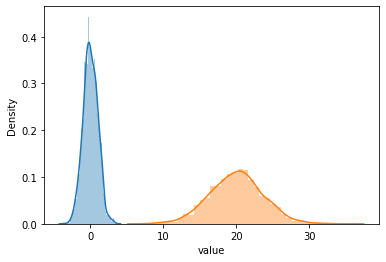

In [33]:
# Create dataset for the gaussian classificatin problem
sample = 2000
class1_df = built_gaussianDataset(0, 1, sample, 0)
class2_df = built_gaussianDataset(20, 3.5, sample, 1)

classes_df = pd.concat([class1_df, class2_df], axis=0)
display(classes_df.head())

sns.distplot(class1_df.value)
sns.distplot(class2_df.value)
plt.show()

In [34]:
# Define my label and features
myfeatures = ['value']
mylabel = 'class'
test_size = 0.2

# Create my test and train subsets
train_classes_df, test_classes_df = split_dataset(classes_df, myfeatures, mylabel, test_size)

Length dataset 4000
Train subset 3200
Test subset 800


In [35]:
# Create feature layers for model
my_features_layer = prepare_numericFeatures(myfeatures)

Epoch 1/40
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1349/1360 [============================>.] - ETA: 0s - loss: 0.0935 - mean_squared_error: 0.0930WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'value': <tf.Tensor 'ExpandDims:0' shape=(2, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
1360/1360 [==============================] - 3s 2ms/step - loss: 0.0933 - mean_squared_error: 0.0928 - val_loss: 0.0313 - val_mean_squared_error: 0.0307
Epoch 2/40
1360/1360 [==============================] - 2s 2ms/step - loss: 0.0295 - mean_squared_error: 0.0288 - val_loss: 0.0161 - val_mean_squared_error: 0.0154
Epoch 3/40
1360/1360 [==============================] - 2s 2ms/step - loss: 0.0163 - mean_squared_error: 0.0155 - val_loss: 0.0110 - val_mean_squared_error: 0.0101
Epoch 4/40
1360/1360 [==============================] -

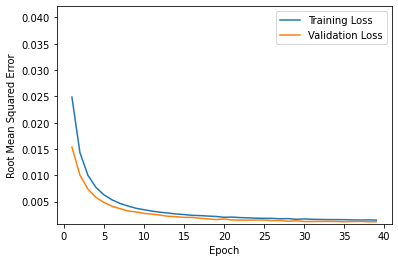


 Evaluate the new model against the test set:
400/400 [==============================] - 0s 1ms/step - loss: 0.0034 - mean_squared_error: 0.0015


(array([[0.4377]], dtype=float32), array([-3.3481], dtype=float32))

In [36]:
# Execute model
execute_model(train_classes_df, test_classes_df, mylabel, my_features_layer, 
              learning_rate_ = 0.01, 
              regularization_rate_ = 0.01,
              activation_= _activation_dic[1], 
              epochs_ = 40, 
              batch_size_ = 2, 
              validation_split_ = 0.15)

Not linearly separable

,value,class
0,-0.5,0
1,-1.0,0
2,0.8,0
3,-0.9,0
4,-0.5,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


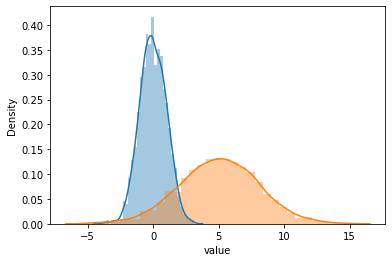

In [37]:
# Create dataset for the gaussian classificatin problem
sample = 2000
class1_df = built_gaussianDataset(0, 1, sample, 0)
class2_df = built_gaussianDataset(5, 3, sample, 1)

classes_df = pd.concat([class1_df, class2_df], axis=0)
display(classes_df.head())

sns.distplot(class1_df.value)
sns.distplot(class2_df.value)
plt.show()

In [38]:
# Define my label and features
myfeatures = ['value']
mylabel = 'class'
test_size = 0.2

# Create my test and train subsets
train_classes_df, test_classes_df = split_dataset(classes_df, myfeatures, mylabel, test_size)

Length dataset 4000
Train subset 3200
Test subset 800


In [39]:
# Create feature layers for model
my_features_layer = prepare_numericFeatures(myfeatures)

Epoch 1/40
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1276/1280 [============================>.] - ETA: 0s - loss: 0.6215 - mean_squared_error: 0.6033WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'value': <tf.Tensor 'ExpandDims:0' shape=(2, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
1280/1280 [==============================] - 2s 2ms/step - loss: 0.6213 - mean_squared_error: 0.6031 - val_loss: 0.1378 - val_mean_squared_error: 0.1370
Epoch 2/40
1280/1280 [==============================] - 2s 2ms/step - loss: 0.1105 - mean_squared_error: 0.1080 - val_loss: 0.1049 - val_mean_squared_error: 0.1004
Epoch 3/40
1280/1280 [==============================] - 2s 2ms/step - loss: 0.0971 - mean_squared_error: 0.0922 - val_loss: 0.0996 - val_mean_squared_error: 0.0938
Epoch 4/40
1280/1280 [==============================] -

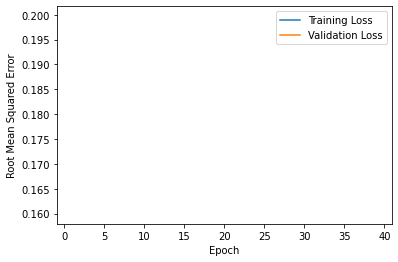


 Evaluate the new model against the test set:
400/400 [==============================] - 0s 1ms/step - loss: 0.0836 - mean_squared_error: 0.0738


(array([[0.9919]], dtype=float32), array([-1.8643], dtype=float32))

In [40]:
# Execute model
execute_model(train_classes_df, test_classes_df, mylabel, my_features_layer, 
              learning_rate_ = 0.01, 
              regularization_rate_ = 0.01,
              activation_= _activation_dic[1], 
              epochs_ = 40, 
              batch_size_ = 2, 
              validation_split_ = 0.2)

### Sine wave regression
Generate pairs of inputs and outputs from sin(2px) . More specifically, take yi = sin(2pxi ) +e , i = 1, …, m, where e is zero-mean Gaussian noise and m is in the neighbourhood of 5 – 10. Use the MSE algorithm to find a polynomial fit for polynomials of order 0, 1, 3, and 9. Once you learn the coefficients of the polynomial, plot the polynomial for x for 0 to 1 with a resolution of 0.01.

In [41]:
#@title Function to generate sine wave.
def sine_wave(sample_):

  fs = 1
  f = 1
  x = np.arange(0+1/sample_,1+1/sample_,1/sample_)
  y = np.sin(2 * np.pi * f * x / fs) + np.random.normal(loc=0, scale=0.05, size=sample_)

  if display:
    plt.plot(x, y)
    plt.xlabel('Sample(n)')
    plt.ylabel('Wave')
    plt.title('Sine wave')
    plt.show()

  return x, y

print("Function created.")

Function created.


In [42]:
#@title Function to generate dataset from polynomal.
def built_polynomialDataset(degree_, lst_values_):

  polynomial = lambda x,p: x**p
  df_new = list()
  for v in lst_values_:
    d = dict()
    for i in np.arange(0,degree_+1):
      name = 'x'+str(i)      
      d[name] = d.get(name, 0) + polynomial(v, i)
    d['y'] = sum(d.values())
    df_new.append(d)
 
  return pd.DataFrame(df_new)
  
print("Function created.")

Function created.


In [43]:
#@title Function to run train model in every polynomial dataset with different order.
def prepare_polynomial_train_test_Datasets(y_, degree_, label_name_, test_size_ = 0.2):
  df = built_polynomialDataset(degree_, y_)
  train_df, test_df = split_dataset(df, df.columns[:-1], label_name_, test_size_, False)

  return df, train_df, test_df

print("Function created.")

Function created.


In [44]:
#@title Function to plot polynomials
def plot_polynomial(order_, constants_, x_inicial_, x_final_, resolution_):

  x = np.arange(x_inicial_, x_final_, resolution_)
  y = list()

  for i in x:
    sum = 0
    for j in np.arange(0, order_+1):
      sum += (constants_[j]*(i**j))
    y.append(sum)

  plt.plot(x,y)
  plt.title("Polynomial order " + str(order_))
  plt.xlabel("x")
  plt.ylabel("y")
  plt.show()

print("Function created.")

Function created.


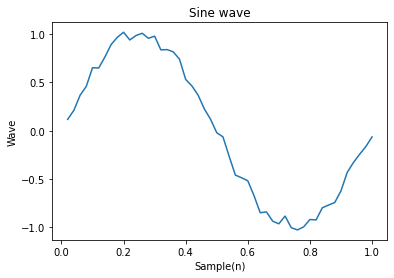

In [45]:
# Create sine wave.
xs, y = sine_wave(50)

# Set my label
mylabel = 'y'

# To plot polynomials
x_inicial = 0
x_final = 1
resolution = 0.01

#### Polynomial with order 0

In [46]:
# Create datasets with 0 order
degree = 0
poly_df, train_poly_df, test_poly_df = prepare_polynomial_train_test_Datasets(y, degree, mylabel)
display(poly_df.head())

# Set features
my_features_layer = prepare_numericFeatures(train_poly_df.columns[:-1])

,x0,y
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
34/34 [==============================] - ETA: 0s - loss: 0.0259 - mean_squared_error: 0.0184WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'x0': <tf.Tensor 'ExpandDims:0' shape=(1, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
34/34 [==============================] - 0s 7ms/step - loss: 0.0258 - mean_squared_error: 0.0184 - val_loss: 0.0226 - val_mean_squared_error: 0.0151
Epoch 2/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0217 - mean_squared_error: 0.0141 - val_loss: 0.0193 - val_mean_squared_error: 0.0116
Epoch 3/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0186 - mean_squared_error: 0.0109 - val_loss: 0.0167 - val_mean_squared_error: 0.0089
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 0.

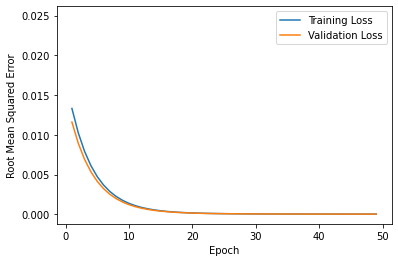


 Evaluate the new model against the test set:
10/10 [==============================] - 0s 1ms/step - loss: 0.0083 - mean_squared_error: 2.2267e-05


In [47]:
# Execute model
weights, bias = execute_model(train_poly_df, test_poly_df, mylabel, my_features_layer, 
                              learning_rate_ = 0.001, 
                              regularization_rate_ = 0.01,
                              activation_= _activation_dic[0], 
                              epochs_ = 50, 
                              batch_size_ = 1, 
                              validation_split_ = 0.15)

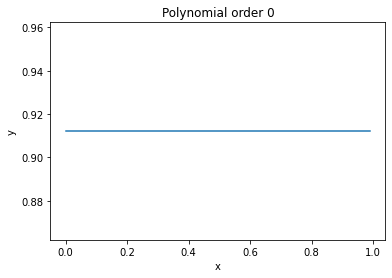

In [48]:
plot_polynomial(degree, weights, x_inicial, x_final, resolution)

#### Polynomial with order 1

In [49]:
# Create datasets with 0 order
degree = 1
poly_df, train_poly_df, test_poly_df = prepare_polynomial_train_test_Datasets(y, degree, mylabel)
display(poly_df.head())

# Set features
my_features_layer = prepare_numericFeatures(train_poly_df.columns[:-1])

,x0,x1,y
0,1.0,0.1,1.1
1,1.0,0.2,1.2
2,1.0,0.4,1.4
3,1.0,0.5,1.5
4,1.0,0.7,1.7


Epoch 1/200
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/17 [>.............................] - ETA: 3s - loss: 12.5365 - mean_squared_error: 12.3891WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'x0': <tf.Tensor 'ExpandDims:0' shape=(2, 1) dtype=float32>, 'x1': <tf.Tensor 'ExpandDims_1:0' shape=(2, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 13ms/step - loss: 7.4948 - mean_squared_error: 7.3526 - val_loss: 6.3425 - val_mean_squared_error: 6.2112
Epoch 2/200
17/17 [==============================] - 0s 4ms/step - loss: 5.8863 - mean_squared_error: 5.7591 - val_loss: 5.7272 - val_mean_squared_error: 5.6103
Epoch 3/200
17/17 [==============================] - 0s 4ms/step - loss: 3.7332 - mean_squared_error: 3.6188 - val_loss: 5.1817 - val_mean_squared_error: 5.0776
Epoch

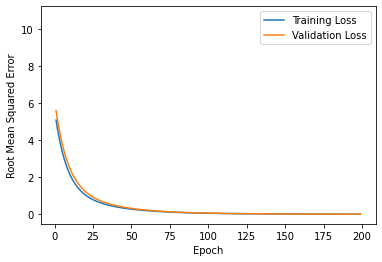


 Evaluate the new model against the test set:
5/5 [==============================] - 0s 2ms/step - loss: 0.0668 - mean_squared_error: 0.0105


In [50]:
# Execute model
weights, bias = execute_model(train_poly_df, test_poly_df, mylabel, my_features_layer, 
                              learning_rate_ = 0.001, 
                              regularization_rate_ = 0.08,
                              activation_= _activation_dic[0], 
                              epochs_ = 200, 
                              batch_size_ = 2, 
                              validation_split_ = 0.15)

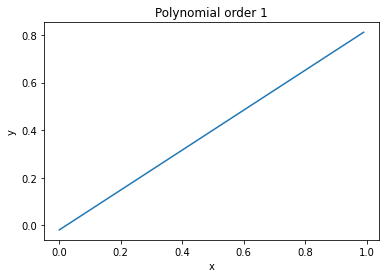

In [51]:
plot_polynomial(degree, weights, x_inicial, x_final, resolution)

#### Polynomial with order 3

In [52]:
# Create datasets with 3 order
degree = 3
poly_df, train_poly_df, test_poly_df = prepare_polynomial_train_test_Datasets(y, degree, mylabel)
display(poly_df.head())

# Set features
my_features_layer = prepare_numericFeatures(train_poly_df.columns[:-1])

,x0,x1,x2,x3,y
0,1.0,0.1,0.0,0.0,1.1
1,1.0,0.2,0.0,0.0,1.3
2,1.0,0.4,0.1,0.0,1.6
3,1.0,0.5,0.2,0.1,1.8
4,1.0,0.7,0.4,0.3,2.4


Epoch 1/40
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
31/34 [==========================>...] - ETA: 0s - loss: 12.4867 - mean_squared_error: 12.4241WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'x0': <tf.Tensor 'ExpandDims:0' shape=(1, 1) dtype=float32>, 'x1': <tf.Tensor 'ExpandDims_1:0' shape=(1, 1) dtype=float32>, 'x2': <tf.Tensor 'ExpandDims_2:0' shape=(1, 1) dtype=float32>, 'x3': <tf.Tensor 'ExpandDims_3:0' shape=(1, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
34/34 [==============================] - 0s 7ms/step - loss: 12.1675 - mean_squared_error: 12.1055 - val_loss: 4.9450 - val_mean_squared_error: 4.8967
Epoch 2/40
34/34 [==============================] - 0s 3ms/step - loss: 9.2732 - mean_squared_error: 9.2293 - val_loss: 3.7297 - val_mean_squared_error: 3.6946
Epoch 3/40
34/34 [=======================

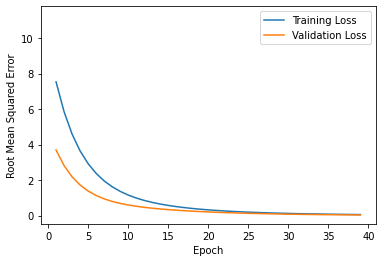


 Evaluate the new model against the test set:
10/10 [==============================] - 0s 2ms/step - loss: 0.1681 - mean_squared_error: 0.0608


In [53]:
# Execute model
weights, bias = execute_model(train_poly_df, test_poly_df, mylabel, my_features_layer, 
                              learning_rate_ = 0.001, 
                              regularization_rate_ = 0.05,
                              activation_= _activation_dic[0], 
                              epochs_ = 40, 
                              batch_size_ = 1, 
                              validation_split_ = 0.15)

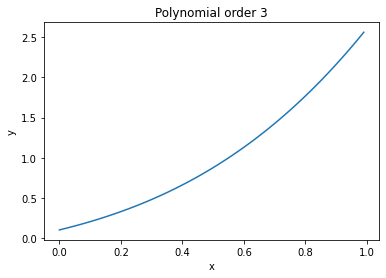

In [54]:
plot_polynomial(degree, weights, x_inicial, x_final, resolution)

#### Polynomial with order 9

In [55]:
# Create datasets with 9 order
degree = 9
poly_df, train_poly_df, test_poly_df = prepare_polynomial_train_test_Datasets(y, degree, mylabel)
display(poly_df.head())

# Set features
my_features_layer = prepare_numericFeatures(train_poly_df.columns[:-1])

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1
1,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3
2,1.0,0.4,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6
3,1.0,0.5,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,1.8
4,1.0,0.7,0.4,0.3,0.2,0.1,0.1,0.0,0.0,0.0,2.8


Epoch 1/80
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
30/34 [=========================>....] - ETA: 0s - loss: 24.3975 - mean_squared_error: 24.3746 WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'x0': <tf.Tensor 'ExpandDims:0' shape=(1, 1) dtype=float32>, 'x1': <tf.Tensor 'ExpandDims_1:0' shape=(1, 1) dtype=float32>, 'x2': <tf.Tensor 'ExpandDims_2:0' shape=(1, 1) dtype=float32>, 'x3': <tf.Tensor 'ExpandDims_3:0' shape=(1, 1) dtype=float32>, 'x4': <tf.Tensor 'ExpandDims_4:0' shape=(1, 1) dtype=float32>, 'x5': <tf.Tensor 'ExpandDims_5:0' shape=(1, 1) dtype=float32>, 'x6': <tf.Tensor 'ExpandDims_6:0' shape=(1, 1) dtype=float32>, 'x7': <tf.Tensor 'ExpandDims_7:0' shape=(1, 1) dtype=float32>, 'x8': <tf.Tensor 'ExpandDims_8:0' shape=(1, 1) dtype=float32>, 'x9': <tf.Tensor 'ExpandDims_9:0' shape=(1, 1) dtype=float32>}
Consider rewriting this mode

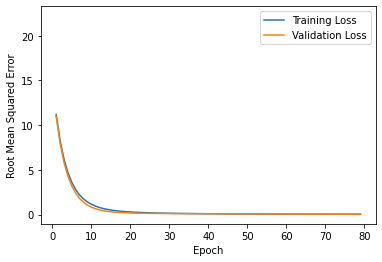


 Evaluate the new model against the test set:
10/10 [==============================] - 0s 3ms/step - loss: 0.1159 - mean_squared_error: 0.0166


In [56]:
# Execute model
weights, bias = execute_model(train_poly_df, test_poly_df, mylabel, my_features_layer, 
                              learning_rate_ = 0.001, 
                              regularization_rate_ = 0.01,
                              activation_= _activation_dic[0], 
                              epochs_ = 80, 
                              batch_size_ = 1, 
                              validation_split_ = 0.15)

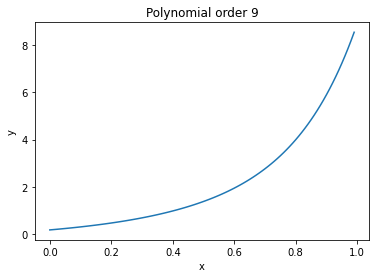

In [57]:
plot_polynomial(degree, weights, x_inicial, x_final, resolution)